<center><img src="images/header.png"></center>

<h1><center>Алгоритмы интеллектуальной обработки больших объемов данных</center></h1>
<hr>
<h2><center>Деревья решений, случайные леса (практика)</center></h2>

**Срок сдачи:** 3 апреля 2017, 06:00 <br> 
**Штраф за опоздание:** -2 балла после 06:00 3 апреля, -4 балла после 06:00 10 апреля, -6 баллов после 06:00 17 апреля

При отправлении ДЗ указывайте фамилию в названии файла<br>

Не забудте создать задание в Slack через /todo.

Используйте данный Ipython Notebook при оформлении домашнего задания.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

In [2]:
from tqdm import tqdm_notebook

for i in tqdm_notebook(xrange(1000000)):
    pass

# Практика

### Качество вина (10 баллов)

Давайте все-таки разберемся с [вином](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv)!


#### Задание (1 балл)
* Загрузите данные, выполните преобразование целевой переменной: 
    * quality > 5 -> 1
    * quality <= 5 -> 0
* Разделите выборку на обучающую и контрольную в пропорции 80/20

In [3]:
df = pd.read_csv('winequality-red.csv', sep=';')
#df.loc[:, 'quality'] = (df.loc[:, 'quality'] > 5).astype(int)
df.quality = (df.quality > 5).astype(int)
df.quality.value_counts()

1    855
0    744
Name: quality, dtype: int64

In [4]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [6]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2)
print len(df), len(df_train), len(df_test)

1599 1279 320


#### Задание (2 балла)

Сфокусируемся на одном гиперпараметре деревьев решений - максимальной глубине.

Подберите наилучшую глубину `d` дерева с помошью 
* Усредненной оценки качества roc-auc на кросс-валидации при различных `d`
* Валидационных кривых

In [7]:
from sklearn.tree import DecisionTreeClassifier

try:
    from sklearn.model_selection import cross_val_score
except ImportError:
    from sklearn.cross_validation import cross_val_score

try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve

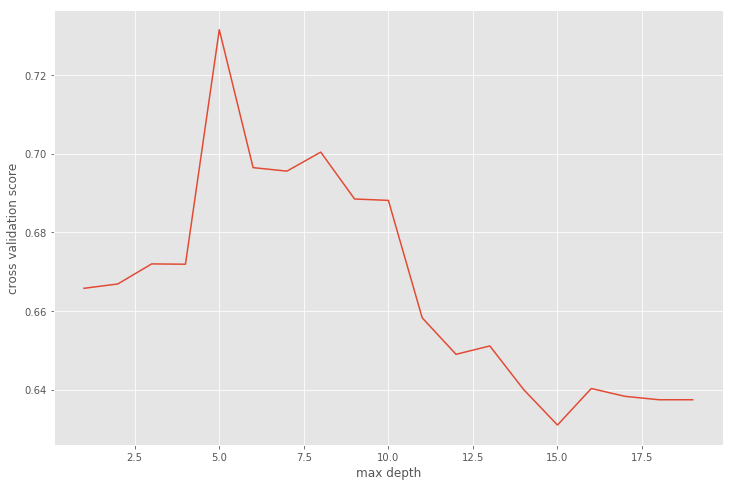

In [47]:
val = []

for i in xrange(1,20):
    tree = DecisionTreeClassifier(max_depth=i, random_state=1)
    scores = cross_val_score(tree, X=df.iloc[:,0:-1], y=df.iloc[:,-1], cv=5, scoring='f1')
    val.append(scores.mean())
    
plt.plot(xrange(1,20), val)
plt.ylabel('cross validation score')
plt.xlabel('max depth')

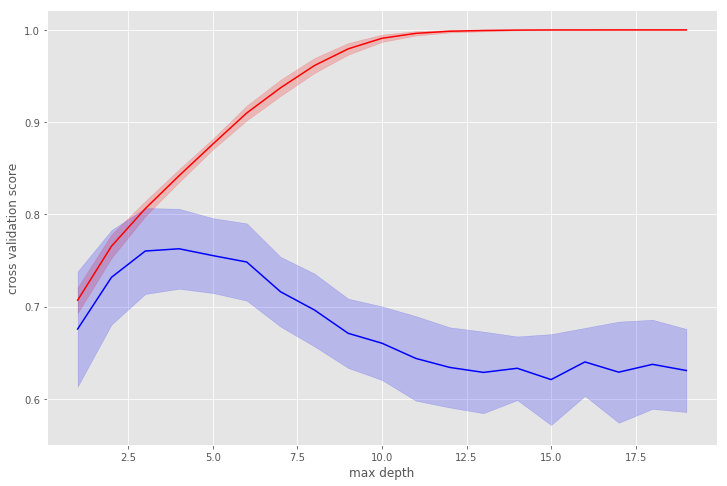

In [38]:
tree = DecisionTreeClassifier()
train_scores, test_scores = validation_curve(tree, X=df.iloc[:,0:-1], y=df.iloc[:,-1], param_name='max_depth', param_range=range(1,20), cv=5, scoring='roc_auc')

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_std = test_scores.std(axis=1)

X = xrange(1,20)
plt.plot(X, train_mean, color='r')
plt.fill_between(X, train_mean+train_std, train_mean-train_std ,color='r', alpha=0.2)
plt.plot(X, test_mean, color='b')
plt.fill_between(X, test_mean+test_std, test_mean-test_std ,color='b', alpha=0.2)

plt.ylabel('cross validation score')
plt.xlabel('max depth')

Метрика : оптимальный параметр

roc_auc   : 4
accuracy  : 5
precision : 4
recall    : 5
F1        : 5

Большинством голосов получается, что оптимальная глубина дерева равна 5. Переобучение еще не сильное, а на тестовой выборке качество классификации максимальное.

#### Задание (1 балл)

Отсортируйте признаки по важности. Вектор с важностью признаков можно получить с помощью `model.feature_importances_`

In [10]:
model = DecisionTreeClassifier(max_depth=5, random_state=1)
model.fit(X=df.iloc[:,0:-1], y=df.iloc[:,-1])
indices = np.argsort(model.feature_importances_)
sorted_features = df.columns[indices]
print 'Вектор важности:\n', model.feature_importances_
print '\nСписок признаков:\n', df.columns
print '\nОтсортированные по важности признаки (самые важные - в конце):\n', sorted_features

Вектор важности:
[ 0.06655055  0.08313722  0.00983134  0.00559642  0.01148551  0.01455628
  0.11612107  0.          0.02907788  0.18826979  0.47537394]

Список признаков:
Index([u'fixed acidity', u'volatile acidity', u'citric acid',
       u'residual sugar', u'chlorides', u'free sulfur dioxide',
       u'total sulfur dioxide', u'density', u'pH', u'sulphates', u'alcohol',
       u'quality'],
      dtype='object')

Отсортированные по важности признаки (самые важные - в конце):
Index([u'density', u'residual sugar', u'citric acid', u'chlorides',
       u'free sulfur dioxide', u'pH', u'fixed acidity', u'volatile acidity',
       u'total sulfur dioxide', u'sulphates', u'alcohol'],
      dtype='object')


#### Задание (2 балла)
* Получите предсказания на тестовой выборке
* Постройте ROC кривые для обучающей и тестовой выборок
* Посчитайте остальные меры качества классификации при пороге в `0.5`

In [11]:
model = DecisionTreeClassifier(max_depth=5, random_state=1)
model.fit(df_train.iloc[:,0:-1], df_train.iloc[:,-1])

#вероятности классов
labels_train = model.predict_proba(df_train.iloc[:,0:-1])
labels_test = model.predict_proba(df_test.iloc[:,0:-1])

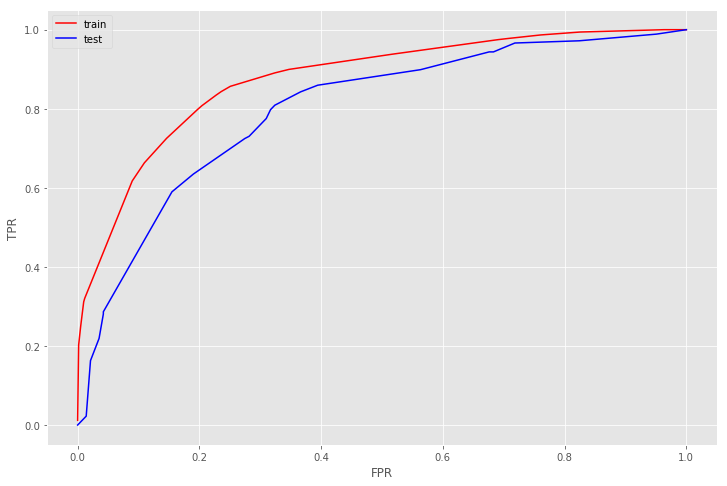

In [12]:
from sklearn.metrics import roc_curve

fpr_train, tpr_train, thresholds_train = roc_curve(df_train.iloc[:,-1], labels_train[:,1])
fpr_test, tpr_test, thresholds_test = roc_curve(df_test.iloc[:,-1], labels_test[:,1])
 
plt.plot(fpr_train, tpr_train, color='r', label='train')
plt.plot(fpr_test, tpr_test, color='b', label='test')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')

Бинаризуем массив вероятностей классов на тестовой выборке с порогом 0,5:

In [33]:
from sklearn.preprocessing import Binarizer

bnr = Binarizer(threshold=0.5)
test_classes = labels_test[:,1].reshape(1, -1)
true_classes = df_test.iloc[:,-1].values.reshape(1, -1)
scores_test = bnr.fit_transform(test_classes).astype(int)
print scores_test

[[0 1 1 0 1 0 1 0 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1
  1 1 0 0 1 0 0 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1 0 0
  1 0 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 0 0 1 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0
  1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 0 1 1
  1 1 0 0 1 1 0 0 0 0 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 1 1 0 0 0 1 1 1 1 0 0 0
  1 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1
  1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 0 1 1 1 1 0 1 0 0 0 1
  0 0 1 0 0 1 1 0 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1
  1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 1]]


In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print 'Accuracy = ', accuracy_score(true_classes[0], scores_test[0])
print 'Precision = ', precision_score(true_classes[0], scores_test[0])
print 'Recall = ', recall_score(true_classes[0], scores_test[0])
print 'F1 = ', f1_score(true_classes[0], scores_test[0])
print 'ROC auc = ', roc_auc_score(true_classes[0], labels_test[:,1])

 Accuracy =  0.746875
Precision =  0.75935828877
Recall =  0.797752808989
F1 =  0.778082191781
ROC auc =  0.798385820541


#### Задание (1 балл)
Перейдем к модели случайного леса. Зафиксируем некоторую глубину дерева (можно взять оптимальное с предыдущих заданий).

Сравните качество работы 
* Простого дерева решений
* Бэггинга над 10,20,...,100 деревьями решений
* Случайного леса с 10,20,...,100 деревьями решений

Получите график, у которого по оси X откладывается количество деревьев, а по оси Y - качество классификации.

In [37]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

In [241]:
# Your Code Here

####  Задание (3 балла)
* С помощью `GridSearchCV` или `RandomSearchCV` подберите наиболее оптимальные параметры для случайного леса.
* Для этих параметров сравните средние результаты по кросс-валидации и качество на контрольной выборке

In [ ]:
# Your Code Here